## Compare the trained models
Load the checkpoints, get the test datamodel up and running, access the two channel output.

In [1]:
import torch
from mimo.models.mimo_unet import MimoUnetModel
from mimo.tasks.sen12tp.sen12tp_datamodule import get_datamodule
from argparse import Namespace
import matplotlib.pyplot as plt
import numpy as np

### First, load up the Gaussian model ('MIMO_NDVI_Prediction_Gauss')

In [6]:
args = {
    'seed': 1,
    'checkpoint_path': 'MIMO_NDVI_Prediction_Gauss/1yt2l40t/checkpoints/last.ckpt',
    'dataset_dir': '/deepskieslab/rnevin/zenodo_data',
    'batch_size': 32,
    'num_loss_function_params': 2,
    'num_subnetworks': 2,
    'filter_base_count': 30,
    'center_dropout_rate': 0.1,
    'final_dropout_rate': 0.1,
    'encoder_dropout_rate': 0.0,
    'core_dropout_rate': 0.0,
    'decoder_dropout_rate': 0.0,
    'loss_buffer_size': 10,
    'loss_buffer_temperature': 0.3,
    'input_repetition_probability': 0.0,
    'batch_repetitions': 1,
    'patch_size': 256,
    'stride': 249,
    'loss': 'gaussian_nll',  # Adjust based on your actual loss function
    'weight_decay': 0.0001,
    'learning_rate': 0.0001,
    'num_workers': 30,
    'training_set_percentage': 1.0,
}

args["input"] = ["VV_sigma0", "VH_sigma0"]
args["target"] = ["NDVI"]  # Example target

'''
python scripts/train/train_ndvi.py   --max_epochs 40   --batch_size 32   -t NDVI   -i VV_sigma0   -i VH_sigma0   --project "MIMO_NDVI_Prediction_Gauss"
'''



args = Namespace(**args)  # Convert dictionary to Namespace
dm_gauss = get_datamodule(args)



# Instantiate the model (ensure to use the same parameters as during training)
model_gauss = MimoUnetModel(
    in_channels=len(dm_gauss.model_inputs),
    out_channels=len(dm_gauss.model_targets) * args.num_loss_function_params,
    num_subnetworks=args.num_subnetworks,
    filter_base_count=args.filter_base_count,
    center_dropout_rate=args.center_dropout_rate,
    final_dropout_rate=args.final_dropout_rate,
    encoder_dropout_rate=args.encoder_dropout_rate,
    core_dropout_rate=args.core_dropout_rate,
    decoder_dropout_rate=args.decoder_dropout_rate,
    loss_buffer_size=args.loss_buffer_size,
    loss_buffer_temperature=args.loss_buffer_temperature,
    input_repetition_probability=args.input_repetition_probability,
    batch_repetitions=args.batch_repetitions,
    loss=args.loss,
    weight_decay=args.weight_decay,
    learning_rate=args.learning_rate,
    seed=args.seed,
)

# this is a necessary step because it adds extra prefix from the wrapper
model_gauss.compile()

#print(args)
# Load the checkpoint
checkpoint = torch.load(args.checkpoint_path, map_location=torch.device('cpu'))
#print(checkpoint.keys())
model_gauss.load_state_dict(checkpoint['state_dict'])

# Set the model to evaluation mode
model_gauss.eval()

📦 Total patches loaded: 134080
🗺️ Total unique scenes: 2095
📚 Training scenes: 1865
🧪 Validation scenes: 230
✅ Final train patches: 119360
✅ Final val patches: 14720


/tmp/ipykernel_1017/1701249722.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(args.checkpoint_path, map_location=torch.device('cpu'))


MimoUnetModel(
  (loss_fn): GaussianNLL()
  (model): OptimizedModule(
    (_orig_mod): MimoUNet(
      (encoder): SubnetworkEncoder(
        (in_convs): ModuleList(
          (0-1): 2 x DoubleConv(
            (double_conv): Sequential(
              (0): Conv2d(2, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
              (1): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
              (3): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
              (4): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (5): ReLU(inplace=True)
              (6): Dropout2d(p=0.0, inplace=False)
            )
          )
        )
        (down1s): ModuleList(
          (0-1): 2 x Down(
            (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
            (conv): DoubleConv(
  

## Now load the Laplace one

In [7]:
args = {
    'seed': 1,
    'checkpoint_path': 'dataset_split/tzgpy7z5/checkpoints/last.ckpt',
    #'checkpoint_path': 'MIMO NDVI Prediction/hhid6a04/checkpoints/last.ckpt',
    'dataset_dir': '/deepskieslab/rnevin/zenodo_data',
    'batch_size': 32,
    'num_loss_function_params': 2,
    'num_subnetworks': 2,
    'filter_base_count': 30,
    'center_dropout_rate': 0.1,
    'final_dropout_rate': 0.1,
    'encoder_dropout_rate': 0.0,
    'core_dropout_rate': 0.0,
    'decoder_dropout_rate': 0.0,
    'loss_buffer_size': 10,
    'loss_buffer_temperature': 0.3,
    'input_repetition_probability': 0.0,
    'batch_repetitions': 1,
    'patch_size': 256,
    'stride': 249,
    'loss': 'laplace_nll',  # Adjust based on your actual loss function
    'weight_decay': 0.0001,
    'learning_rate': 0.0001,
    'num_workers': 30,
    'training_set_percentage': 1.0,
}

args["input"] = ["VV_sigma0", "VH_sigma0"]
args["target"] = ["NDVI"]  # Example target

'''
python scripts/train/train_ndvi.py   --max_epochs 40   --batch_size 32   -t NDVI   -i VV_sigma0   -i VH_sigma0   --project "MIMO_NDVI_Prediction_Gauss"
'''

args = Namespace(**args)  # Convert dictionary to Namespace
dm_laplace = get_datamodule(args)



# Instantiate the model (ensure to use the same parameters as during training)
model_laplace = MimoUnetModel(
    in_channels=len(dm_laplace.model_inputs),
    out_channels=len(dm_laplace.model_targets) * args.num_loss_function_params,
    num_subnetworks=args.num_subnetworks,
    filter_base_count=args.filter_base_count,
    center_dropout_rate=args.center_dropout_rate,
    final_dropout_rate=args.final_dropout_rate,
    encoder_dropout_rate=args.encoder_dropout_rate,
    core_dropout_rate=args.core_dropout_rate,
    decoder_dropout_rate=args.decoder_dropout_rate,
    loss_buffer_size=args.loss_buffer_size,
    loss_buffer_temperature=args.loss_buffer_temperature,
    input_repetition_probability=args.input_repetition_probability,
    batch_repetitions=args.batch_repetitions,
    loss=args.loss,
    weight_decay=args.weight_decay,
    learning_rate=args.learning_rate,
    seed=args.seed,
)

# this is a necessary step because it adds extra prefix from the wrapper
model_laplace.compile()

print(args)
# Load the checkpoint
checkpoint = torch.load(args.checkpoint_path, map_location=torch.device('cpu'))
print(checkpoint.keys())
model_laplace.load_state_dict(checkpoint['state_dict'])

# Set the model to evaluation mode
model_laplace.eval()

📦 Total patches loaded: 134080
🗺️ Total unique scenes: 2095
📚 Training scenes: 1865
🧪 Validation scenes: 230
✅ Final train patches: 119360
✅ Final val patches: 14720
Namespace(seed=1, checkpoint_path='dataset_split/tzgpy7z5/checkpoints/last.ckpt', dataset_dir='/deepskieslab/rnevin/zenodo_data', batch_size=32, num_loss_function_params=2, num_subnetworks=2, filter_base_count=30, center_dropout_rate=0.1, final_dropout_rate=0.1, encoder_dropout_rate=0.0, core_dropout_rate=0.0, decoder_dropout_rate=0.0, loss_buffer_size=10, loss_buffer_temperature=0.3, input_repetition_probability=0.0, batch_repetitions=1, patch_size=256, stride=249, loss='laplace_nll', weight_decay=0.0001, learning_rate=0.0001, num_workers=30, training_set_percentage=1.0, input=['VV_sigma0', 'VH_sigma0'], target=['NDVI'])


/tmp/ipykernel_1017/305430800.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(args.checkpoint_path, map_location=torch.device('cpu'))


dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers', 'MixedPrecision', 'hparams_name', 'hyper_parameters'])


MimoUnetModel(
  (loss_fn): LaplaceNLL()
  (model): OptimizedModule(
    (_orig_mod): MimoUNet(
      (encoder): SubnetworkEncoder(
        (in_convs): ModuleList(
          (0-1): 2 x DoubleConv(
            (double_conv): Sequential(
              (0): Conv2d(2, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
              (1): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
              (3): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
              (4): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (5): ReLU(inplace=True)
              (6): Dropout2d(p=0.0, inplace=False)
            )
          )
        )
        (down1s): ModuleList(
          (0-1): 2 x Down(
            (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
            (conv): DoubleConv(
   

I need to compare the two datamodels and make sure they're the same. I think they should be ...

In [8]:
# Now we can use the model to make predictions
test_data_gauss = dm_gauss.train_dataloader()  # Ensure the dataloader is set up for your test dataset
test_data_laplace = dm_laplace.train_dataloader()

torch.Size([32, 2, 2, 256, 256])
(2, 32, 2, 1, 256, 256)
<class 'tuple'>


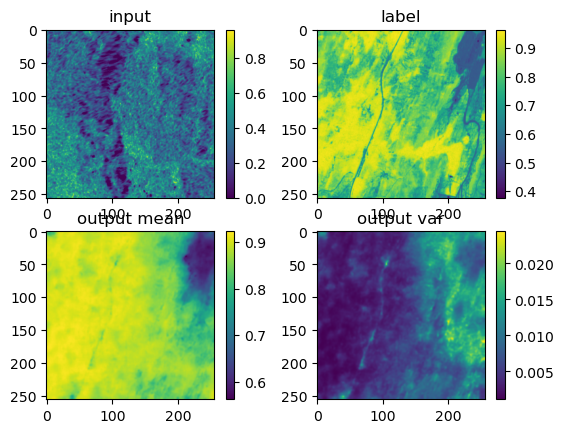

torch.Size([32, 2, 2, 256, 256])
(2, 32, 2, 1, 256, 256)
<class 'tuple'>


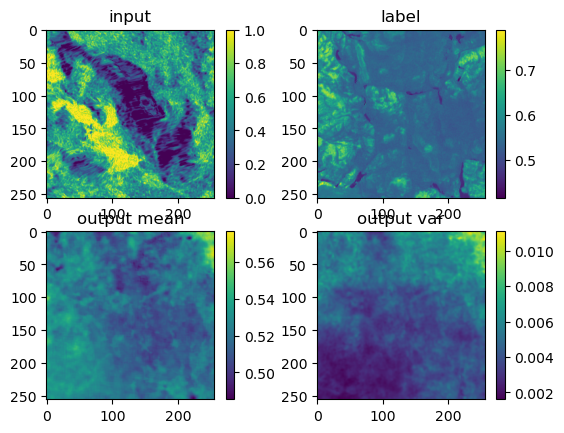

torch.Size([32, 2, 2, 256, 256])
(2, 32, 2, 1, 256, 256)
<class 'tuple'>


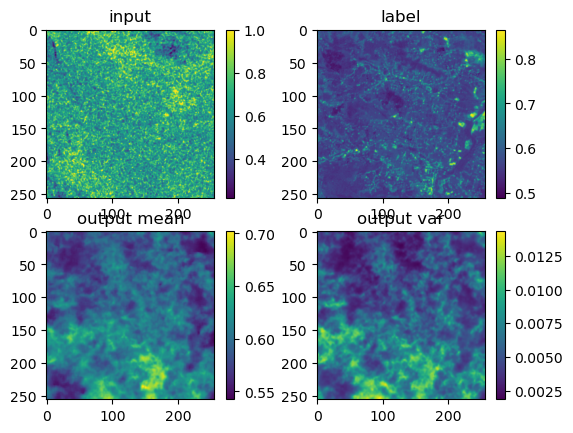

torch.Size([32, 2, 2, 256, 256])
(2, 32, 2, 1, 256, 256)
<class 'tuple'>


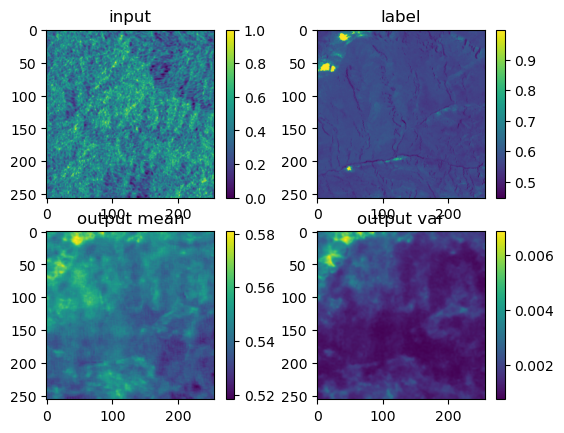

torch.Size([32, 2, 2, 256, 256])
(2, 32, 2, 1, 256, 256)
<class 'tuple'>


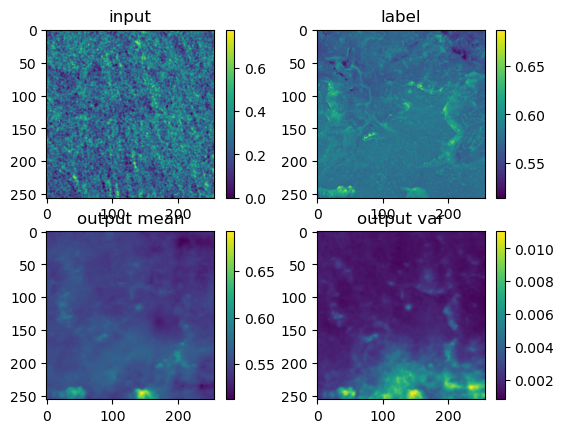

torch.Size([32, 2, 2, 256, 256])
(2, 32, 2, 1, 256, 256)
<class 'tuple'>


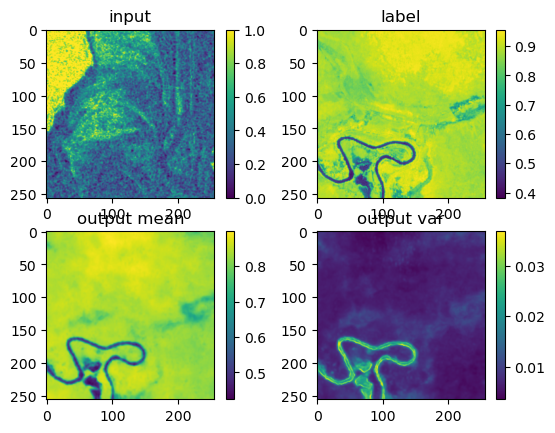

NameError: name 'STOP' is not defined

In [9]:
plot = True
counter = 0
# Make predictions
predictions_gauss = []
labels_gauss = []
with torch.no_grad():
    for inputs in test_data_gauss:
        image_tensor = inputs["image"]  # Extract the tensor
        label_tensor = inputs["label"]
        

        image_tensor = image_tensor.unsqueeze(1) # adding subnetwork channel
        # (B, S, C, H, W) = x.shape
        # batch, # subnetworks, channels, height, width
        
        # now duplicate, this saves on memory
        image_tensor = image_tensor.expand(-1, 2, -1, -1, -1)
        # this is the option that creates actual copies
        # image_tensor = image_tensor.repeat(1, 2, 1, 1, 1)
        
        if plot:
            print(np.shape(image_tensor))
            fig = plt.figure()
            ax0 = fig.add_subplot(221)
            im0 = ax0.imshow(image_tensor[1,0,0,:,:])
            plt.colorbar(im0)
            ax0.set_title('input')
    
            ax1 = fig.add_subplot(222)
            im1 = ax1.imshow(label_tensor[0,0,:,:])
            plt.colorbar(im1)
            ax1.set_title('label')
        
        outputs = model_gauss(image_tensor)  # Pass only the tensor to the model
        
        if plot:
            print(np.shape(outputs))
            print(type(outputs))
    
            output_mean = outputs[0]
            output_f2 = outputs[1]
            
            mean = output_mean[0, 0, 0, :, :].cpu().detach().numpy()
            f2 = output_f2[0, 0, 0, :, :].cpu().detach().numpy()
    
            ax2 = fig.add_subplot(223)
            im2 = ax2.imshow(mean)
            plt.colorbar(im2)
            ax2.set_title('output mean')
    
            ax3 = fig.add_subplot(224)
            im3 = ax3.imshow(np.exp(f2))
            plt.colorbar(im3)
            ax3.set_title('output var')
            plt.show()

        # make an image for if this is well calibrated
        
        labels_gauss.append(label_tensor)
        predictions_gauss.append(outputs)
        counter+=1
        if counter > 5:
            STOP



### Second, load up the Laplacian model ('MIMO NDVI Prediction')

In [11]:
print(np.shape(labels_laplace), np.shape(predictions_laplace))

(6, 32, 1, 256, 256) (6, 2, 32, 2, 1, 256, 256)


torch.Size([32, 2, 2, 256, 256])
(2, 32, 2, 1, 256, 256)
<class 'tuple'>


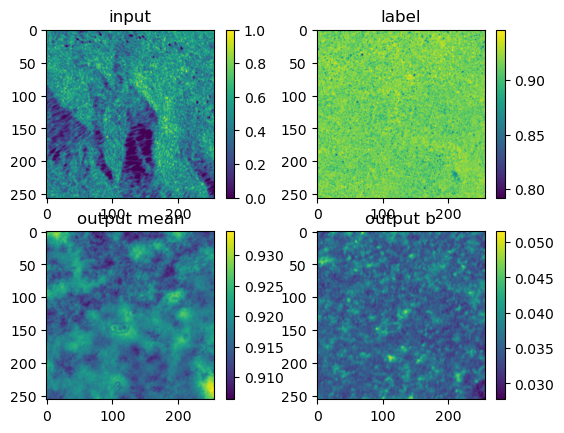

torch.Size([32, 2, 2, 256, 256])
(2, 32, 2, 1, 256, 256)
<class 'tuple'>


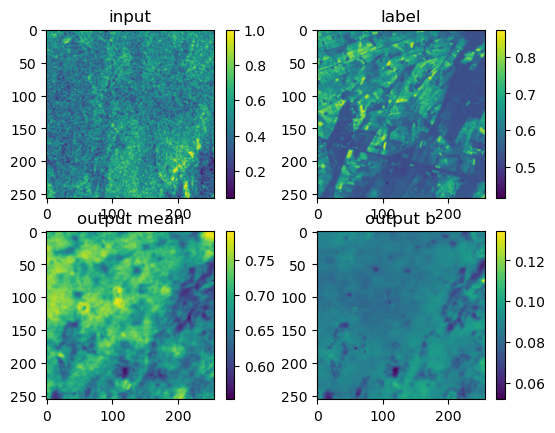

torch.Size([32, 2, 2, 256, 256])
(2, 32, 2, 1, 256, 256)
<class 'tuple'>


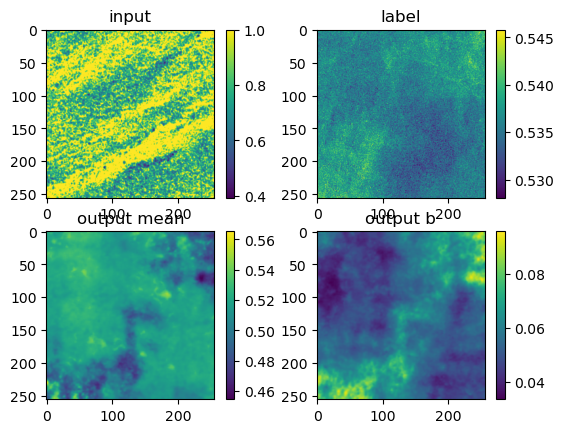

torch.Size([32, 2, 2, 256, 256])
(2, 32, 2, 1, 256, 256)
<class 'tuple'>


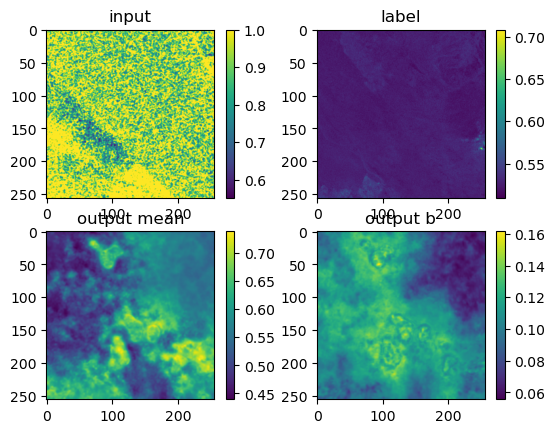

torch.Size([32, 2, 2, 256, 256])
(2, 32, 2, 1, 256, 256)
<class 'tuple'>


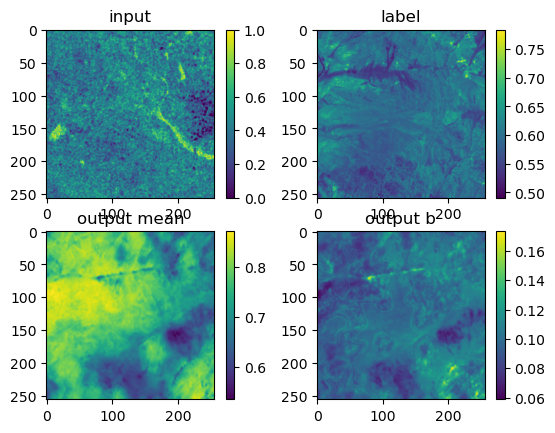

torch.Size([32, 2, 2, 256, 256])
(2, 32, 2, 1, 256, 256)
<class 'tuple'>


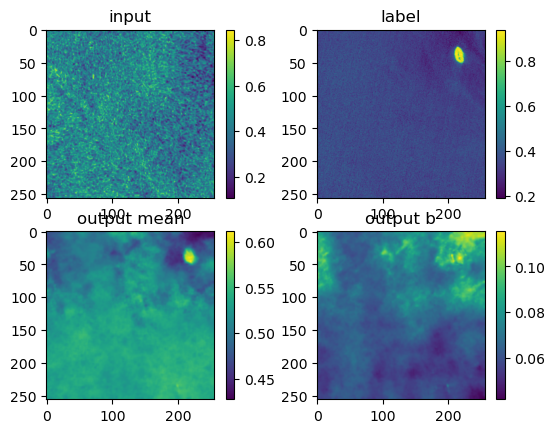

In [20]:
# Make predictions
predictions_laplace = []
labels_laplace = []
counter = 0
with torch.no_grad():
    for inputs in test_data_laplace:
        image_tensor = inputs["image"]  # Extract the tensor
        label_tensor = inputs["label"]

        image_tensor = image_tensor.unsqueeze(1) # adding subnetwork channel
        # (B, S, C, H, W) = x.shape
        # batch, # subnetworks, channels, height, width
        
        # now duplicate, this saves on memory
        image_tensor = image_tensor.expand(-1, 2, -1, -1, -1)
        # this is the option that creates actual copies
        # image_tensor = image_tensor.repeat(1, 2, 1, 1, 1)
        if plot:
            print(np.shape(image_tensor))
            fig = plt.figure()
            ax0 = fig.add_subplot(221)
            im0 = ax0.imshow(image_tensor[1,0,0,:,:])
            plt.colorbar(im0)
            ax0.set_title('input')
    
            ax1 = fig.add_subplot(222)
            im1 = ax1.imshow(label_tensor[0,0,:,:])
            plt.colorbar(im1)
            ax1.set_title('label')
        
        
        outputs = model_laplace(image_tensor)  # Pass only the tensor to the model
        if plot:
            print(np.shape(outputs))
            print(type(outputs))
    
            output_mean = outputs[0]
            output_f2 = outputs[1]
            
            mean = output_mean[0, 0, 0, :, :].cpu().detach().numpy()
            f2 = output_f2[0, 0, 0, :, :].cpu().detach().numpy()
    
            ax2 = fig.add_subplot(223)
            im2 = ax2.imshow(mean)
            plt.colorbar(im2)
            ax2.set_title('output mean')
    
            ax3 = fig.add_subplot(224)
            im3 = ax3.imshow(np.exp(f2))
            plt.colorbar(im3)
            ax3.set_title('output b')
            plt.show()

        labels_laplace.append(label_tensor)
        predictions_laplace.append(outputs)
        counter+=1
        if counter > 5:
            break



In [19]:
print(np.shape(labels_gauss), np.shape(predictions_gauss))
print(np.shape(labels_laplace), np.shape(predictions_laplace))

(6, 32, 1, 256, 256) (6, 2, 32, 2, 1, 256, 256)
(6, 32, 1, 256, 256) (6, 2, 32, 2, 1, 256, 256)


<Figure size 640x480 with 0 Axes>

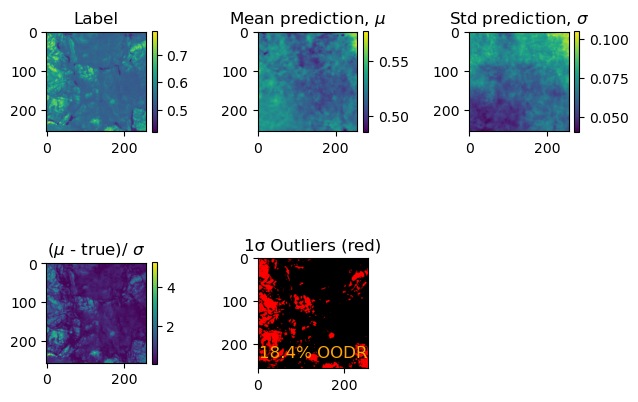

In [17]:
n = 1

true_gauss = labels_gauss[n][0,0,:,:]

plt.clf()
fig = plt.figure()
ax0 = fig.add_subplot(231)
im0 = ax0.imshow(true_gauss)
plt.colorbar(im0, fraction=0.046)
ax0.set_title('Label')

mean_gauss = predictions_gauss[n][0][0, 0, 0, :, :].cpu().detach().numpy()
f2_gauss = predictions_gauss[n][1][0, 0, 0, :, :].cpu().detach().numpy()

ax1 = fig.add_subplot(232)
im1 = ax1.imshow(mean_gauss)
plt.colorbar(im1, fraction=0.046)
ax1.set_title(r'Mean prediction, $\mu$')

ax2 = fig.add_subplot(233)
im2 = ax2.imshow(np.exp(f2_gauss)**(0.5))
plt.colorbar(im2, fraction=0.046)
ax2.set_title(r'Std prediction, $\sigma$')

# the question 'is it calibrated'

ax3 = fig.add_subplot(234)
im3 = ax3.imshow(abs((mean_gauss - true_gauss.detach().numpy())/(np.exp(f2_gauss)**(0.5))))
plt.colorbar(im3, fraction=0.046)
ax3.set_title(r'($\mu$ - true)/ $\sigma$')

# Calculate Z-score image
z_img = np.abs((mean_gauss - true_gauss.detach().numpy()) / (np.exp(f2_gauss)**(0.5)))

# Create outlier mask (pixels where z > 4)
outlier_mask = z_img > 1

# Create RGB image to highlight outliers in red
outlier_rgb = np.zeros((*z_img.shape, 3))
outlier_rgb[outlier_mask] = [1, 0, 0]  # red

# Plot it in ax4
ax4 = fig.add_subplot(235)
im4 = ax4.imshow(outlier_rgb)
ax4.set_title("1σ Outliers (red)")

# Calculate percentage of outlier pixels
percent_outliers = 100 * np.sum(outlier_mask) / outlier_mask.size
ax4.text(0.5, 0.1, f"{percent_outliers:.1f}% OODR",
         transform=ax4.transAxes, ha="center", fontsize=12, color='orange')

plt.tight_layout()
plt.savefig("OODR_gauss.png")
plt.show()

<Figure size 640x480 with 0 Axes>

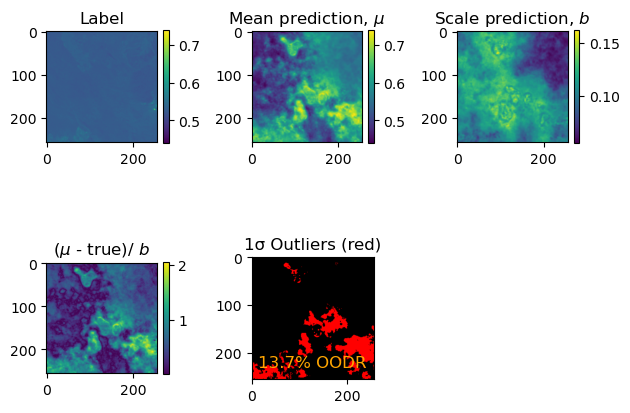

In [34]:
n = 3
true_laplace = labels_laplace[n][0,0,:,:]

mean_laplace = predictions_laplace[n][0][0, 0, 0, :, :].cpu().detach().numpy()
f2_laplace = predictions_laplace[n][1][0, 0, 0, :, :].cpu().detach().numpy()

min_value = np.min([np.min(mean_laplace), np.min(true_laplace.cpu().detach().numpy())])
max_value = np.max([np.max(mean_laplace), np.max(true_laplace.cpu().detach().numpy())])


plt.clf()
fig = plt.figure()
ax0 = fig.add_subplot(231)
im0 = ax0.imshow(true_laplace, vmin = min_value, vmax = max_value)
plt.colorbar(im0, fraction=0.046)
ax0.set_title('Label')


ax1 = fig.add_subplot(232)
im1 = ax1.imshow(mean_laplace, vmin = min_value, vmax = max_value)
plt.colorbar(im1, fraction=0.046)
ax1.set_title(r'Mean prediction, $\mu$')

ax2 = fig.add_subplot(233)
im2 = ax2.imshow(np.exp(f2_laplace))
plt.colorbar(im2, fraction=0.046)
ax2.set_title(r'Scale prediction, $b$')

# the question 'is it calibrated'

ax3 = fig.add_subplot(234)
im3 = ax3.imshow(abs((mean_laplace - true_laplace.detach().numpy())/np.exp(f2_laplace)))
plt.colorbar(im3, fraction=0.046)
ax3.set_title(r'($\mu$ - true)/ $b$')

# Calculate Z-score image
z_img = np.abs((mean_laplace - true_laplace.detach().numpy()) / np.exp(f2_laplace))

# Create outlier mask (pixels where z > 4)
outlier_mask = z_img > 1

# Create RGB image to highlight outliers in red
outlier_rgb = np.zeros((*z_img.shape, 3))
outlier_rgb[outlier_mask] = [1, 0, 0]  # red

# Plot it in ax4
ax4 = fig.add_subplot(235)
im4 = ax4.imshow(outlier_rgb)
ax4.set_title("1σ Outliers (red)")

# Calculate percentage of outlier pixels
percent_outliers = 100 * np.sum(outlier_mask) / outlier_mask.size
ax4.text(0.5, 0.1, f"{percent_outliers:.1f}% OODR",
         transform=ax4.transAxes, ha="center", fontsize=12, color='orange')

plt.tight_layout()
plt.savefig("OODR_laplace_"+str(n)+".png")
plt.show()

In [ ]:
def compute_pixelwise_ece(
    y_true, y_pred, y_uncertainty, num_bins=10, error_type="absolute"):
    """
    Compute Expected Calibration Error (ECE) for pixel-wise uncertainty calibration.
    
    Parameters:
    - y_true: np.ndarray, ground truth values (H, W)
    - y_pred: np.ndarray, predicted values (H, W)
    - y_uncertainty: np.ndarray, predicted uncertainties (H, W)
    - num_bins: int, number of bins for uncertainty calibration
    - error_type: str, "absolute" for MAE, "squared" for MSE
    
    Returns:
    - ece: float, the expected calibration error
    """

    # Flatten arrays to handle pixel-wise values
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    y_uncertainty = y_uncertainty.flatten()

    # Compute empirical error
    if error_type == "absolute":
        empirical_error = np.abs(y_pred - y_true)
    elif error_type == "squared":
        empirical_error = (y_pred - y_true) ** 2
    else:
        raise ValueError("error_type must be 'absolute' or 'squared'.")

    # Define bin edges for uncertainty
    bin_edges = np.linspace(y_uncertainty.min(), y_uncertainty.max(), num_bins + 1)
    
    # Initialize ECE
    ece = 0.0
    ece_bin = []
    total_pixels = len(y_true)

    # Compute ECE over bins
    for i in range(num_bins):
        bin_mask = (y_uncertainty >= bin_edges[i]) & (y_uncertainty < bin_edges[i + 1])
        bin_size = np.sum(bin_mask)
        
        if bin_size > 0:
            avg_pred_uncertainty = np.mean(y_uncertainty[bin_mask])
            avg_empirical_error = np.mean(empirical_error[bin_mask])

            ece += (bin_size / total_pixels) * np.abs(avg_pred_uncertainty - avg_empirical_error)
            ece_bin.append((bin_size / total_pixels) * np.abs(avg_pred_uncertainty - avg_empirical_error))
    return ece, bin_edges, ece_bin

In [ ]:
y_true = true_laplace.detach().numpy()
y_pred = mean_laplace
y_uncertainty = np.exp(f2_laplace)**(0.5)

ece_value, bin_edges, ece_bin = compute_pixelwise_ece(y_true, y_pred, y_uncertainty, num_bins=15, error_type="absolute")
print(f"Pixel-wise ECE: {ece_value:.4f}")

In [ ]:
# Compute bin centers for better visualization
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Midpoints of bins

# Create histogram using bar plot
plt.bar(bin_centers, ece_bin, width=np.diff(bin_edges), align="center", edgecolor="black")

# Labels and title
plt.xlabel("Predicted Uncertainty")
plt.ylabel("ECE Contribution per Bin")
plt.title("ECE Contribution Histogram")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Create figure and main axis
fig, ax = plt.subplots(figsize=(8, 6))

# Main bar plot
ax.bar(bin_centers, ece_bin, width=np.diff(bin_edges), align="center", edgecolor="black")
ax.set_xlabel("Predicted Uncertainty")
ax.set_ylabel("ECE Contribution per Bin")
ax.set_title("ECE Contribution Histogram")
ax.grid(axis="y", linestyle="--", alpha=0.7)

# **Inset panel settings** (adjust size and position)
inset_size = "25%"  # Percentage of main figure size
inset_positions = [(0.65, 0.6), (0.15, 0.6), (0.40, 0.2)]  # (x, y) relative to figure

img_min = min([np.min(y_true), np.min(y_pred)])
img_max = max([np.max(y_true), np.max(y_pred)])

# **Inset 1: True values (y_true)**
ax_inset1 = inset_axes(ax, width="50%", height="50%", loc="upper left",
                        bbox_to_anchor=(0.0, 0.6, 0.3, 0.3), bbox_transform=ax.transAxes)
ax_inset1.imshow(y_true, cmap="viridis",
                vmin=img_min,
                vmax=img_max)
ax_inset1.set_title("True Values", fontsize=8)
ax_inset1.axis("off")

# **Inset 2: Predicted values (y_pred)**
ax_inset2 = inset_axes(ax, width="50%", height="50%", loc="upper left",
                        bbox_to_anchor=(0.15, 0.6, 0.3, 0.3), bbox_transform=ax.transAxes)
ax_inset2.imshow(y_pred, cmap="viridis",
                vmin=img_min,
                vmax=img_max)
ax_inset2.set_title("Predicted Values", fontsize=8)
ax_inset2.axis("off")

# **Inset 3: Uncertainty values (y_uncertainty)**
ax_inset3 = inset_axes(ax, width="50%", height="50%", loc="upper left",
                        bbox_to_anchor=(0.3, 0.6, 0.3, 0.3), bbox_transform=ax.transAxes)
ax_inset3.imshow(y_uncertainty, cmap="viridis")
ax_inset3.set_title("Uncertainty", fontsize=8)
ax_inset3.axis("off")
plt.savefig("ECE_gauss.png")
plt.show()